# ESMPy regridding with Fields containing ungridded dimensions

This example demonstrates how to regrid a field with extra dimensions, such as time and vertical layers.

In [1]:
# conda create -n esmpy-ugrid-example -c ioos esmpy matplotlib krb5 jupyter netCDF4
# source activate esmpy-ugrid-example
# jupyter notebook

In [2]:
import esmpy
import numpy

Download data files using ESMPy utilities, if they are not downloaded already.

In [3]:
import os
DD = os.path.join(os.getcwd(), "ESMPy-data")
if not os.path.isdir(DD):
    os.makedirs(DD)
from esmpy.util.cache_data import cache_data_file
cache_data_file(os.path.join(DD, "ll2.5deg_grid.nc"))
cache_data_file(os.path.join(DD, "T42_grid.nc"))
print('Done.')

Done.


Set the number of elements in the extra field dimensions

In [4]:
levels = 2
time = 5

Create two uniform global latlon grids from a SCRIP formatted files

In [5]:
srcgrid = esmpy.Grid(filename="ESMPy-data/ll2.5deg_grid.nc", 
                    filetype=esmpy.FileFormat.SCRIP,
                    add_corner_stagger=True)
dstgrid = esmpy.Grid(filename="ESMPy-data/T42_grid.nc", 
                    filetype=esmpy.FileFormat.SCRIP,
                    add_corner_stagger=True)

Create Fields on the center stagger locations of the Grids, specifying that they will have ungridded dimensions using the 'ndbounds' argument

In [6]:
srcfield = esmpy.Field(srcgrid, name='srcfield',
                      staggerloc=esmpy.StaggerLoc.CENTER,
                      ndbounds=[levels, time])
dstfield = esmpy.Field(dstgrid, name='dstfield',
                      staggerloc=esmpy.StaggerLoc.CENTER,
                      ndbounds=[levels, time])
xctfield = esmpy.Field(dstgrid, name='xctfield',
                      staggerloc=esmpy.StaggerLoc.CENTER,
                      ndbounds=[levels, time])

Get the coordinates of the source Grid and initialize the source Field

In [7]:
[lon,lat] = [0, 1]
gridXCoord = srcfield.grid.get_coords(lon, esmpy.StaggerLoc.CENTER)
gridYCoord = srcfield.grid.get_coords(lat, esmpy.StaggerLoc.CENTER)

deg2rad = 3.14159/180

for timestep in range(time):
    for level in range(levels):
        srcfield.data[:,:,level,timestep]=10.0*(level+timestep+1) + \
                                          (gridXCoord*deg2rad)**2 + \
                                          (gridXCoord*deg2rad)*\
                                          (gridYCoord*deg2rad) + \
                                          (gridYCoord*deg2rad)**2

Get the coordinates of the destination Grid and initialize the exact solution and destination Field

In [8]:
gridXCoord = xctfield.grid.get_coords(lon, esmpy.StaggerLoc.CENTER)
gridYCoord = xctfield.grid.get_coords(lat, esmpy.StaggerLoc.CENTER)

for timestep in range(time):
    for level in range(levels):
        xctfield.data[:,:,level,timestep]=10.0*(level+timestep+1) + \
                                          (gridXCoord*deg2rad)**2 + \
                                          (gridXCoord*deg2rad)*\
                                          (gridYCoord*deg2rad) + \
                                          (gridYCoord*deg2rad)**2

dstfield.data[...] = 1e20

Create an object to regrid data from the source to the destination Field

In [9]:
regrid = esmpy.Regrid(srcfield, dstfield,
                     regrid_method=esmpy.RegridMethod.CONSERVE,
                     unmapped_action=esmpy.UnmappedAction.ERROR)

Call the regridding operator on this Field pair

In [10]:
dstfield = regrid(srcfield, dstfield)

Display regridding results

MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

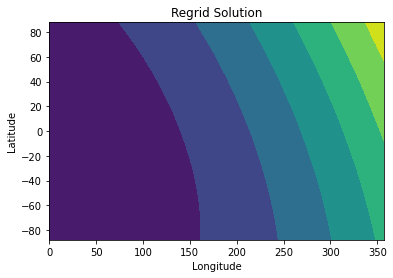

In [11]:
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline

lons = dstfield.grid.get_coords(0)
lats = dstfield.grid.get_coords(1)

fig = plt.figure()
ax = plt.axes(xlim=(numpy.min(lons), numpy.max(lons)),
              ylim=(numpy.min(lats), numpy.max(lats)))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Regrid Solution")

def animate(i):
    z = dstfield.data[:,:,0,i]
    cont = plt.contourf(lons, lats, z)
    return cont

anim = animation.FuncAnimation(fig, animate, frames=time)

anim.save('ESMPyRegrid.mp4')

plt.show()